In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import copy
import networkx as nx
import pandas as pd
from matplotlib.patches import Patch
import time

In [2]:
from multisoc.generate.multidimensional_network import multidimensional_network_fix_av_degree
from multisoc.generate.two_dimensional_population import consol_comp_pop_frac_tnsr
from multisoc.generate.two_dimensional_population import relative_correlation_inv
from multisoc.generate.utils import make_composite_index
from multisoc.theory.multidimensional_preferences import composite_H
from multisoc.metrics.fairness_metrics import *
from multisoc.theory.fairness_metrics import *

In [3]:
from helpers_for_viz import *

## Preamble for figures

In [4]:
color_dict = {
	    (0,0):"#8A2846",
	    (0,1):"#03045E",
	    (1,0):"#FFC2D4",
	    (1,1):"#CAF0F8"
	    }
groups_lst = [(0,0),(0,1),(1,0),(1,1)]
group_labels = [["f","m"],["C","D"]]
colors_race = ["#595959","#d9d9d9"]
colors_gender = ["#c63963","#3A6CC6"]

## Common parameters

In [5]:
seed = 6 ## for reproducibility
np.random.seed(seed) ## 99,5,6!!

In [6]:
## Number of nodes and links
N = 100 ## Number of nodes
m = 10  ## Average number of connections per node
g_vec = [2,2]

kind = "all" ## Aggregation function: {all->and, one->mean, any->or}
p_d = [0.5, 0.5] ## Weight of each dimension for "mean" aggregation function

In [12]:
## Preferences
h_cat = 0.9
h_dog = 0.9

h_f = 0.9
h_m = 0.9

## List of 1d homophily matrices (2 for a two-dimensional system)
h_mtrx_lst = [ 
    
    np.array([[h_cat,1-h_cat],
              [1-h_dog,h_dog]]),
    
    np.array([[h_f,1-h_f],
              [1-h_m,h_m]])
]

## Population distribution

In [13]:
## Population distribution
f_cat = 0.32
f_f = 0.46

assert f_cat < f_f

pop_fracs_lst = [
    [f_cat,1-f_cat],
    [f_f,1-f_f]
]

correlation = 0.0 ## Try: -0.9,-0.3,0,0.3,0.9
consol = relative_correlation_inv(f_f,correlation)
comp_pop_frac_tnsr = consol_comp_pop_frac_tnsr(pop_fracs_lst,consol)

In [14]:
H = composite_H(h_mtrx_lst,"all")
F = comp_pop_frac_tnsr
predicted_onedim_ineq = analytical_1vRest_onedimensional_deltas(H,F,N)
predicted_onedim_ineq

{0: {0: -0.9500462372333369, 1: 0.9500462372333369},
 1: {0: -0.23249573641292706, 1: 0.23249573641292706}}

## Generate networks

In [15]:
G = multidimensional_network_fix_av_degree(
                h_mtrx_lst,
                comp_pop_frac_tnsr,
                kind,
                directed=True, ## Directed or undirected network
                pop_fracs_lst = pop_fracs_lst,
                N=N,
                m=m,
                v = 0,
                p_d = p_d
                )

In [120]:
G_1d = multidimensional_network_fix_av_degree(
                [h_mtrx_lst[0]],
                np.array(pop_fracs_lst[0]),
                kind,
                directed=True, ## Directed or undirected network
                pop_fracs_lst = [pop_fracs_lst[0]],
                N=N,
                m=m,
                v = 0,
                p_d = p_d
                )

## Remove isolated nodes
G_1d.remove_nodes_from(list(nx.isolates(G_1d)))

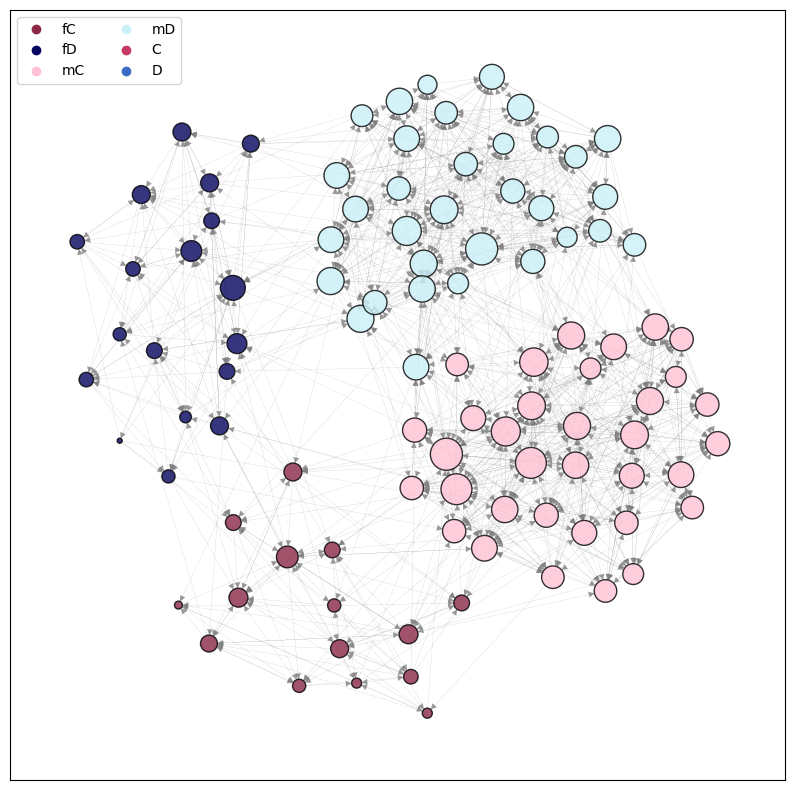

In [16]:
## Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))
_ = draw_2d_network(G)
plt.show()

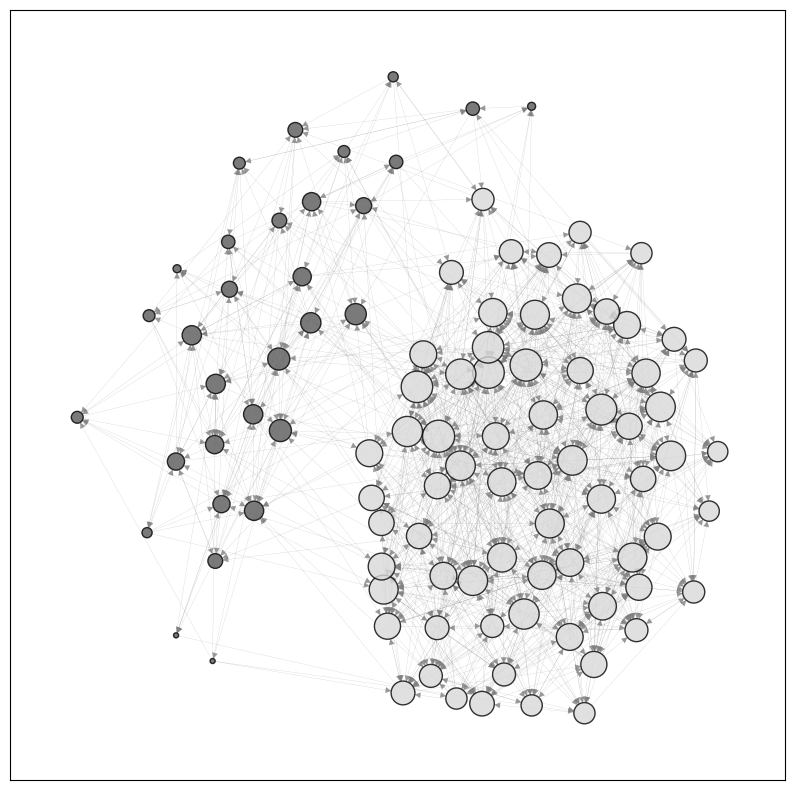

In [14]:
_ = draw_2d_network(G_1d,color_dict = {(0,):colors_race[0],(1,):colors_race[1]})
plt.show()

## Export networks

In [76]:
G_export = copy.deepcopy(G)
for n,info in G_export.nodes.items():
    G_export.nodes[n]["attr_name"] = tuple([group_labels[d][gi] for d,gi in enumerate(G_export.nodes[n]["attr"])])
G_json = nx.node_link_data(G_export)

for i,n in enumerate(G_json["nodes"]):
    for k, v in n.items():
        if type(v) == np.int32:
            G_json["nodes"][i][k] = int(v)

for i,n in enumerate(G_json["links"]):
    for k, v in n.items():
        if type(v) == np.int32:
            G_json["links"][i][k] = int(v)

with open("./viz_data/test/example_network.json","w") as f:
    f.write(json.dumps(G_json, indent = 4))

In [12]:
folder = "viz_data"
fname = "test"
save_graph_json(G,group_labels,folder,fname)

## Compute av degrees inequalities

In [17]:
mean_degrees_lst, mean_degrees_1d_lst,group_deg_rank = av_deg_n_network_simulations(
	N,
	m,
	h_mtrx_lst,
	pop_fracs_lst,
	comp_pop_frac_tnsr,
	g_vec,
	directed=True,
	kind = "all",
	p_d = [0.5,0.5],
	iterations = 50,
	)

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
mean_degrees_lst_race, mean_degrees_1d_lst_race, group_deg_rank_race = av_deg_n_network_simulations(
	N,
	m,
	[h_mtrx_lst[0]],
	[pop_fracs_lst[0]],
	np.array(pop_fracs_lst[0]),
	[2],
	directed=True,
	kind = "all",
	p_d = [0.5,0.5],
	iterations = 50,
	)

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
mean_degrees_lst_sex, mean_degrees_1d_lst_sex, group_deg_rank_sex = av_deg_n_network_simulations(
	N,
	m,
	[h_mtrx_lst[1]],
	[pop_fracs_lst[1]],
	np.array(pop_fracs_lst[1]),
	[2],
	directed=True,
	kind = "all",
	p_d = [0.5,0.5],
	iterations = 50,
	)

  0%|          | 0/50 [00:00<?, ?it/s]

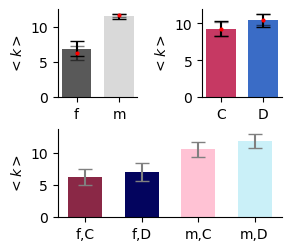

In [20]:
## Degree figure all together
fig = plt.figure(figsize=(0.8*3.5,0.8*3),layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax_top_left = fig.add_subplot(gs[0, 0])
ax_top_right = fig.add_subplot(gs[0, 1])
ax_bottom = fig.add_subplot(gs[1,:])

ax_bottom.spines[['right', 'top']].set_visible(False)
ax_top_left.spines[['right', 'top']].set_visible(False)
ax_top_right.spines[['right', 'top']].set_visible(False)

mean_degrees = {gi:np.nanmean(di) for gi,di in mean_degrees_1d_lst[0].items()}
std_degrees = {gi:np.nanstd(di) for gi,di in mean_degrees_1d_lst[0].items()}

plt.sca(ax_top_left)
xbar, ybar = zip(*list(mean_degrees.items()))
plt.bar([group_labels[0][i] for i in xbar],ybar,color=colors_race,width=0.7)
plt.errorbar([0,1],ybar,yerr=[std_degrees[i] for i in [0,1]],ls="",capsize=5,color="k")
plt.ylabel("$<k>$")
# plt.ylim(0,12)

mean_degrees = {gi:np.mean(di) for gi,di in mean_degrees_1d_lst_race[0].items()}
std_degrees = {gi:np.std(di) for gi,di in mean_degrees_1d_lst_race[0].items()}
xbar, ybar = zip(*list(mean_degrees.items()))
# plt.bar([group_labels[0][i] for i in xbar],ybar,color=colors_race,width=0.5,alpha=0.5)
plt.plot([group_labels[0][i] for i in xbar],ybar,"ro",ms=2,zorder=20)
plt.errorbar([0,1],ybar,yerr=[std_degrees[i] for i in [0,1]],ls="",capsize=5,color="k",alpha=0.5)

mean_degrees = {gi:np.nanmean(di) for gi,di in mean_degrees_1d_lst[1].items()}
std_degrees = {gi:np.nanstd(di) for gi,di in mean_degrees_1d_lst[1].items()}

plt.sca(ax_top_right)
xbar, ybar = zip(*list(mean_degrees.items()))
plt.bar([group_labels[1][i] for i in xbar],ybar,color=colors_gender,width=0.7)
plt.errorbar([0,1],ybar,yerr=[std_degrees[i] for i in [0,1]],ls="",capsize=5,color="k")
plt.ylabel("$<k>$")
# plt.ylim(0,12)

mean_degrees = {gi:np.nanmean(di) for gi,di in mean_degrees_1d_lst_sex[0].items()}
std_degrees = {gi:np.nanstd(di) for gi,di in mean_degrees_1d_lst_sex[0].items()}
xbar, ybar = zip(*list(mean_degrees.items()))
# plt.bar([group_labels[1][i] for i in xbar],ybar,color=colors_gender,width=0.5,alpha=0.5)
plt.plot([group_labels[1][i] for i in xbar],ybar,"ro",ms=2,zorder=20)
plt.errorbar([0,1],ybar,yerr=[std_degrees[i] for i in [0,1]],ls="",capsize=5,color="k",alpha=0.5)

mean_degrees = {gi:np.nanmean(di) for gi,di in mean_degrees_lst.items()}
std_degrees = {gi:np.nanstd(di) for gi,di in mean_degrees_lst.items()}

plt.sca(ax_bottom)
xbar, ybar = zip(*list(mean_degrees.items()))
plt.bar([group_labels[0][i[0]]+","+ group_labels[1][i[1]] for i in xbar],
        ybar,
        color=[color_dict[i] for i in groups_lst],
        width=0.6
       )
plt.errorbar(range(4),ybar,yerr=[std_degrees[i] for i in groups_lst],ls="",capsize=5,color="grey")
plt.ylabel("$<k>$")
# plt.ylim(0,12)

plt.show()

## Compute delta inequalities

In [154]:
# %%timeit
full_ineq_dict = get_inequality_info_from_graph(G,g_vec,attribute_key="attr",ineq_fun=common_language_delta)
# full_ineq_dict

node_info_arr = get_attr_degree_from_graph(G,g_vec,attribute_key="attr")

one_dim_degs = get_one_dim_degrees(node_info_arr,g_vec)
multidim_degs = get_multidim_degrees(node_info_arr,g_vec)

sorted_node_info_arr = node_info_arr[node_info_arr[:, -1].argsort()]

### Using multidimensioanl model

In [155]:
# %%timeit
H = composite_H(h_mtrx_lst,"all")
F = comp_pop_frac_tnsr
predicted_onedime_ineq = analytical_1vRest_onedimensional_deltas(H,F,N)
predicted_multi_ineq = analytical_1vRest_multidimensional_deltas(H,F,N)
# predicted_onedime_ineq, predicted_multi_ineq

### One dimension at a time

In [156]:
# %%timeit
onedim_deltas_hypothetical_1d = {}
F = comp_pop_frac_tnsr
for d in range(F.ndim):
    onedim_deltas_hypothetical_1d[d] = {}
    H_theor_1D = h_mtrx_lst[d]
    F_1D = np.array(pop_fracs_lst[d])
    onedim_deltas_hypothetical_i = analytical_1vRest_onedimensional_deltas(H_theor_1D,F_1D,N)
    for vi in range(F.shape[d]):
        onedim_deltas_hypothetical_1d[d][vi] = onedim_deltas_hypothetical_i[0][vi]

In [157]:
onedim_deltas_hypothetical_1d

{0: {0: 0.9999466479814042, 1: -0.9999466479814042},
 1: {0: 0.5791304031543308, 1: -0.5791304031543308}}

## Plot analytical and simulated inequalities

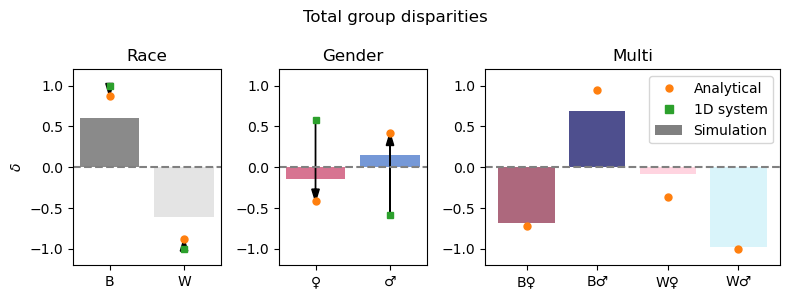

In [158]:
fig, axs = plt.subplots(1,3,figsize=(8,3),width_ratios=[2,2,4])
plt.suptitle("Total group disparities")

plt.sca(axs[0])
plt.title("Race")
plt.bar(["B","W"],[full_ineq_dict["dim0_g0"],full_ineq_dict["dim0_g1"]],alpha=0.7,color=colors_race)
plt.plot([0,1],[predicted_onedime_ineq[0][0],predicted_onedime_ineq[0][1]],"o",color="C1",ms=5)
plt.plot([0,1],[onedim_deltas_hypothetical_1d[0][0],onedim_deltas_hypothetical_1d[0][1]],"s",color="C2",ms=5)
plt.axhline(0,color="grey",ls="--")

plt.arrow(0, onedim_deltas_hypothetical_1d[0][0], 0,predicted_onedime_ineq[0][0]-onedim_deltas_hypothetical_1d[0][0], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")
plt.arrow(1, onedim_deltas_hypothetical_1d[0][1], 0,predicted_onedime_ineq[0][1]-onedim_deltas_hypothetical_1d[0][1], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")


plt.ylim(-1.2,1.2)
plt.ylabel(r"$\delta$")

plt.sca(axs[1])
plt.title("Gender")
plt.bar(["♀","♂"],[full_ineq_dict["dim1_g0"],full_ineq_dict["dim1_g1"]],alpha=0.7,color=colors_gender)
plt.plot([0,1],[predicted_onedime_ineq[1][0],predicted_onedime_ineq[1][1]],"o",color="C1",ms=5)
plt.plot([0,1],[onedim_deltas_hypothetical_1d[1][0],onedim_deltas_hypothetical_1d[1][1]],"s",color="C2",ms=5)
plt.axhline(0,color="grey",ls="--")

plt.arrow(0, onedim_deltas_hypothetical_1d[1][0], 0,predicted_onedime_ineq[1][0]-onedim_deltas_hypothetical_1d[1][0], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")
plt.arrow(1, onedim_deltas_hypothetical_1d[1][1], 0,predicted_onedime_ineq[1][1]-onedim_deltas_hypothetical_1d[1][1], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")

plt.ylim(-1.2,1.2)

plt.sca(axs[2])
plt.title("Multi")
plt.bar(["B♀","B♂","W♀","W♂"],
        [full_ineq_dict["multi(0, 0)"],full_ineq_dict["multi(0, 1)"],full_ineq_dict["multi(1, 0)"],full_ineq_dict["multi(1, 1)"]],
        alpha=0.7,color=[color_dict[i] for i in groups_lst])
plt.plot([0,1,2,3],[predicted_multi_ineq[(0, 0)],predicted_multi_ineq[(0, 1)],predicted_multi_ineq[(1, 0)],predicted_multi_ineq[(1, 1)]],"o",color="C1",ms=5,label="Analytical")
plt.axhline(0,color="grey",ls="--")
plt.plot([],[],"s",color="C2",label="1D system")
plt.bar(0,0,color=["grey"],label="Simulation")
plt.ylim(-1.2,1.2)

plt.legend()
plt.tight_layout()
plt.show()

## TESTS

In [91]:
aa = np.array([
    [(0,0),(0,1),(1,0)],
    [(0,0),(0,1),(1,0)]]
    )

In [95]:
aa == (0,0)

array([[[ True,  True],
        [ True, False],
        [False,  True]],

       [[ True,  True],
        [ True, False],
        [False,  True]]])

In [100]:
np.all(aa == (0,0),axis=2)

array([[ True, False, False],
       [ True, False, False]])

In [101]:
degree_dct = dict(G.in_degree())

In [105]:
sorted_degs = sorted(degree_dct.items(), key=lambda x:x[1],reverse=True)

In [131]:
group_deg_rank = [G.nodes[n[0]]["attr"] for n in sorted_degs]

In [132]:
group_deg_rank = np.array(group_deg_rank)

In [135]:
group_deg_rank.T

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]])

In [125]:
group_deg_rank = np.random.randint(0,2,size=(20,100,2))

In [122]:
np.all(group_deg_rank == np.array((0,0)),axis=2)

ValueError: operands could not be broadcast together with shapes (2,100,20) (2,) 

In [124]:
group_deg_rank

array([[[0, 1, 1, ..., 0, 1, 0],
        [0, 1, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]],

       [[0, 1, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 1, 1],
        [0, 1, 0, ..., 0, 1, 0]]])

In [137]:
np.sum(np.all(group_deg_rank == (0,0),axis=2),axis=0)

AxisError: axis 2 is out of bounds for array of dimension 2

In [140]:
np.all(group_deg_rank == (0,0),axis=1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False])

In [18]:
group_deg_rank.shape

(20, 100, 2)

In [15]:
np.sum(np.all(group_deg_rank == (0,0),axis=2),axis=0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,
        1,  1,  1,  0,  2,  1,  0,  0,  0,  5,  0,  1,  1,  1,  3,  2,  3,
        5, 11,  4, 11,  6, 14, 11, 12, 17, 25, 23, 27, 35, 61, 75])

In [19]:
group_deg_rank.ndim

3

In [24]:
group_deg_rank[:,:,0].shape

(20, 100)

In [25]:
np.all(group_deg_rank == (0,0),axis=2).shape

(20, 100)

In [19]:
rank_prob_dct_multi, rank_prob_dct_1D = analyze_degree_ranking(group_deg_rank, g_vec)

In [18]:
group_degrees_av_std = {gi: (np.nanmean(vals),np.nanstd(vals)) for gi, vals in mean_degrees_lst.items()}

In [25]:
pd.DataFrame.from_dict(group_degrees_av_std,orient="index")

,0,1
"(0, 0)",2.635556,1.131183
"(0, 1)",6.896733,1.328549
"(1, 0)",11.702134,1.138249
"(1, 1)",10.312705,1.167301


In [22]:
group_degrees_av_std

{(0, 0): (2.635555555555556, 1.1311831454905856),
 (0, 1): (6.896733290883047, 1.3285486651152767),
 (1, 0): (11.702134172108282, 1.1382488832839928),
 (1, 1): (10.312704651652648, 1.1673008663242097)}

In [29]:
pd.DataFrame.from_dict(rank_prob_dct_multi,"index").T

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
0,0.00,0.00,0.70,0.30
1,0.00,0.00,0.65,0.35
2,0.00,0.00,0.65,0.35
3,0.00,0.00,0.70,0.30
4,0.00,0.05,0.65,0.30
...,...,...,...,...
95,0.05,0.80,0.05,0.10
96,0.30,0.50,0.15,0.05
97,0.45,0.45,0.00,0.10
98,0.80,0.20,0.00,0.00


In [11]:
uu,oo = aggregate_degree_avs(mean_degrees_lst,mean_degrees_1d_lst,group_labels)

In [12]:
pd.DataFrame(uu)

,dim_1,dim_2,mean,std
0,♀,C,2.607602,1.153817
1,♀,D,6.904164,1.321607
2,♂,C,11.692832,1.136536
3,♂,D,10.270938,1.159950


In [13]:
pd.DataFrame(oo)

,dim,group,mean,std
0,1,♀,6.384917,1.126499
1,1,♂,11.195427,0.225571
2,2,C,11.020795,1.208090
3,2,D,8.978470,0.997289


In [27]:
rank_prob_dct_multi.keys()

dict_keys([(0, 0), (0, 1), (1, 0), (1, 1)])

In [33]:
pd.DataFrame.from_dict(rank_prob_dct_1D[1],"index").T

,0,1
0,0.70,0.30
1,0.65,0.35
2,0.65,0.35
3,0.70,0.30
4,0.65,0.35
...,...,...
95,0.10,0.90
96,0.45,0.55
97,0.45,0.55
98,0.80,0.20


In [14]:
rank_prob_dct_multi_RLBL, rank_prob_dct_1D_RLBL = label_rankings(rank_prob_dct_multi, rank_prob_dct_1D, group_labels)

In [18]:
pd.DataFrame.from_dict(rank_prob_dct_multi_RLBL,"index").T

,"(♀, C)","(♀, D)","(♂, C)","(♂, D)"
0,0.00,0.00,0.70,0.30
1,0.00,0.00,0.60,0.40
2,0.00,0.00,0.65,0.35
3,0.00,0.00,0.75,0.25
4,0.00,0.05,0.70,0.25
...,...,...,...,...
95,0.05,0.75,0.05,0.15
96,0.30,0.50,0.15,0.05
97,0.40,0.45,0.05,0.10
98,0.80,0.15,0.00,0.05


In [16]:
pd.DataFrame.from_dict(rank_prob_dct_1D_RLBL,"index").T

,♀,♂,C,D
0,0.00,1.00,0.70,0.30
1,0.00,1.00,0.60,0.40
2,0.00,1.00,0.65,0.35
3,0.00,1.00,0.75,0.25
4,0.05,0.95,0.70,0.30
...,...,...,...,...
95,0.80,0.20,0.10,0.90
96,0.80,0.20,0.45,0.55
97,0.85,0.15,0.45,0.55
98,0.95,0.05,0.80,0.20


In [15]:
rank_prob_dct_multi_RLBL

{('♀',
  'C'): array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ,
        0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.05, 0.1 , 0.05,
        0.15, 0.05, 0.1 , 0.1 , 0.15, 0.2 , 0.35, 0.05, 0.3 , 0.45, 0.8 ,
        0.7 ]),
 ('♀',
  'D'): array([0.  , 0.  , 0.  , 0.  , 0.05, 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.05, 0.1 , 0.  , 0.  , 0.05, 0.05, 0.  , 0.  , 0.  , 0.05, 0.05,
        0.05, 0.1 , 0.15, 0.05, 0.  , 0.1 , 0.15, 0.1 , 0.15, 0.15, 0.1 ,
        0.05, 0.05, 0.15, 0.05, 0.1 , 0.05, 0.1 , 0.1 , 0.15, 0.1 , 

In [9]:
res = generate_nw_data_for_viz(
	N,
	m,
	h_mtrx_lst,
	pop_fracs_lst,
	comp_pop_frac_tnsr,
	g_vec,
	group_labels,
	iterations=50,
	directed=True,
	kind = "all",
	p_d = [0.5,0.5],
	)

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\csh_samu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\csh_samu\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
folder = "./viz_data"
fname = "test"
save_viz_data(res,folder,fname)

In [10]:
res[0]

'{\n    "h_f": 0.9,\n    "f_f": 0.25,\n    "h_m": 0.9,\n    "f_m": 0.75,\n    "h_C": 0.9,\n    "f_C": 0.45,\n    "h_D": 0.9,\n    "f_D": 0.55,\n    "F_fC": 0.03375,\n    "F_fD": 0.21625,\n    "F_mC": 0.41625,\n    "F_mD": 0.33375,\n    "corr": 0.52425\n}'

In [14]:
comp_pop_frac_tnsr.shape == (2,2)

True

In [14]:
res[0]

,dim_1,dim_2,mean,std
0,f,C,2.712211,1.082016
1,f,D,6.623797,1.247983
2,m,C,11.677791,1.021519
3,m,D,10.392963,1.239399


In [11]:
import os
os.mkdir("viz_data")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'viz_data'